In [1]:
# https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.insert(1, '../python_scripts/')
from wavenumbers import *
from plot import plot_wavenumber_cloud, plot_acquisition_layout

# Parametrization of the wavenumber cloud

In this notebook we will study the wavenumber cloud and seek a paramatrization.

Reference: [Geophysical Imaging lecture notes](https://www-ljk.imag.fr/membres/Ludovic.Metivier/LECTURE_NOTES/2020_COURS_MSIAM_FWI.pdf)

## 1 - Wavenumbers cloud 

We will use the same layout as in the first notebook, except that we will set $k_0 = 1$, for practical matters, in order to have unit wavenumbers when adequate, so to better vizualize the clouds of points. For that we will use $c_0 = 2\pi$ and $f_0 = 1$.

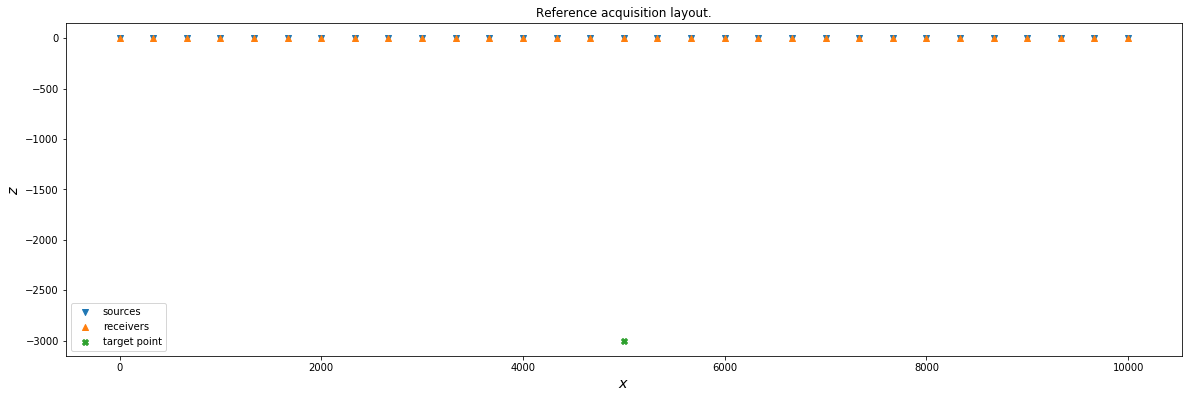

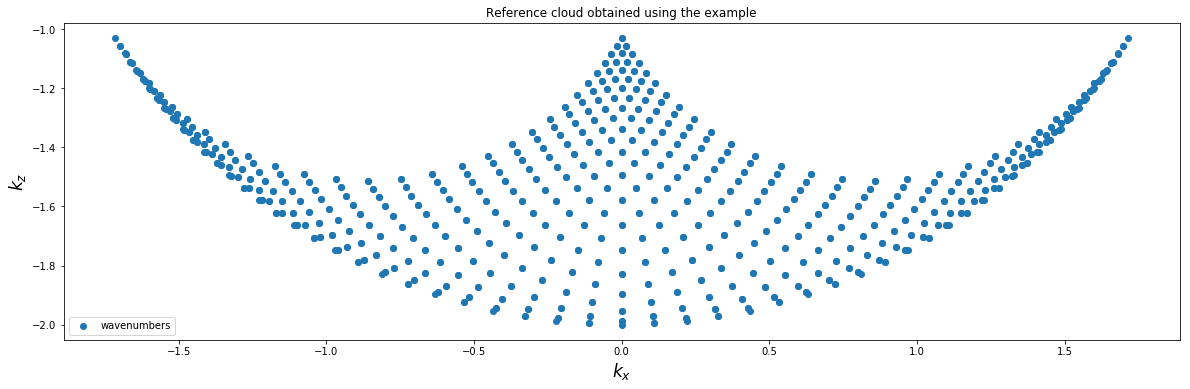

In [2]:
# Data
x_diffraction_pt = np.array([5000, -3000]) # difraction point, fixed throughout the notebook
N = 31 # number of sources and receivers
c0 = 2*np.pi # velocity of the medium
f0 = 1 # # time frequency

# reference sources and receivers
start = 0
stop = 10000
# localizations of the sources
S_ref = np.array([np.linspace(start = start, stop = stop, num = N, dtype = float), np.zeros(N)]).T 
# localizations of the receivers
R_ref = np.array([np.linspace(start = start, stop = stop, num = N, dtype = float), np.zeros(N)]).T 

plot_acquisition_layout(S_ref, R_ref, x_diffraction_pt, title = "Reference acquisition layout.")

# We compute the wavenumbers components of reference
K_ref = wavenumbers_positions_formula(x_diffraction_pt, S_ref, R_ref, c0, f0)
plot_wavenumber_cloud(K_ref, labels = "wavenumbers", title = "Reference cloud obtained using the example", color = 'k')

In [18]:
K_ref
Kx, Kz = extract_coordinates_from_matrix(K_ref)
K = np.array([Kx, Kz])
K.shape

(2, 961)

In [19]:
K_ref.T.shape

(2, 961)

We compute the maximum value $\phi_{max}$ that the angles $\phi_s$ and $\phi_r$ can take; will be useful for 
later angular and circular arcs formulations of the wavenumber components.

In [3]:
PhiS_ref, PhiR_ref = layout2angles(x_diffraction_pt, S_ref, R_ref)
all_angles_abs_value = np.abs(np.concatenate((PhiS_ref, PhiR_ref)))
phi_max = np.amax( all_angles_abs_value )
print("phi_max = ", phi_max, " radians.")

phi_max =  1.0303768265243125  radians.


## 2 - Parametrization of the wavenumbers cloud via circular arcs

In [4]:
def wavenumbers_circular_arcs(PhiS, PhiR, c0, f0):
    """
    Function that generates wavenumbers components from sets of angles phi_s and phi_r using
    the circular arc formulation, each arc will be associated to a source and the points in the arc will be 
    computed by varying the receivers.
    The function is a prrof of concept of the circular arc parametrization of the wavenumber cloud.

    Parameters
    ----------
        PhiS : an array containing the values of the incident angles
        PhiR : an array containing the values of the adjoint angles
        c0 : constant velocity of the medium
        f0 : time frequency

    Returns
    ----------
        K : a 2×n matrix contaning the coordinates of the wavenumbers
        Centers : the centers of the circular arcs, will be computed using the coordinates of the sources
    """

    k0 = (2*np.pi*f0)/c0
    
    K = []
    Centers = []
    
    for phis in PhiS:
        # We first compute the center of the circular arc
        center = k0*np.array([np.sin(phis), - np.cos(phis)])
        Centers.append(center)
        for phir in PhiR: 
            # Computation of the coordinates of the wavenumber
            k = center + k0*np.array([np.cos(phir - np.pi/2), np.sin(phir - np.pi/2)])
            K.append(k)
    
    K = np.array(K)
    Centers = np.array(Centers)

    # We return both the wavenumbers and the arcs centers so we can plot both later on
    return K, Centers

def compute_circular_arcs(PhiS, PhiR, c0, f0):
    """
    Function that computes the circular arcs in the wavenumber cloud that would be generated
    by the angles phi_s and phi_r.
    Again, each arc will be associated to a source and the points in the arc will be 
    computed by varying the receivers.
    The function helps to highlight the circular arcs that compose the wavenumber cloud.

    Parameters
    ----------
        PhiS : an array containing the values of the incident angles
        PhiR : an array containing the values of the adjoint angles
        c0 : constant velocity of the medium
        f0 : time frequency

    Returns
    ----------
        Circular_Arcs : the list of sets of points composing each circular arc
        Centers_Arcs : the list of points that constitute the centers of the arcs
    """
    
    k0 = (2*np.pi*f0)/c0
    
    # A list of the generated circular arcs 
    Circular_Arcs = []
    
    # A list of the centers of the circular arcs and the associated labels
    Centers_Arcs = []
        
    for i in range(PhiS.shape[0]):
        angle = PhiS[i] # the fixed angle corresponding to phi_s
        center = k0*np.array([np.sin(angle), - np.cos(angle)]) # the center of the circular arc
        Circular_Arc = [] # the list of the points in the arc
        for phir in PhiR: 
            # the cartesian coordinates of the points in the arc
            k = center + k0*np.array( [np.cos(phir - np.pi/2), np.sin(phir - np.pi/2)])
            Circular_Arc.append( k )
        
        Circular_Arcs.append(np.array(Circular_Arc))
        Centers_Arcs.append(center.reshape(1,2))
        
    return Circular_Arcs, Centers_Arcs

### 2.1 - The wavenumbers cloud as a set of circular arcs

Let us fix one angle. Without loss of generality, let us say the source is fixed and has an angle $\phi_s = a \in [- \phi_{max}, \phi_{max}]$, while the other angle $\phi_r$ varies between $- \phi_{max}$ and $\phi_{max}$. Here $\phi_{max}$ denotes the largest value the angles can take and is related to the farthest source and receiver from the diffraction point. We consider our layout to be symmetric with regards to the diffraction point. For any $\phi_r$ we would have

$$ k = k_0 \begin{bmatrix} \sin a + \sin \phi_r \\ -  \cos a -  \cos \phi_r  \end{bmatrix} = 
k_0 \begin{bmatrix} \sin a  \\ -  \cos a   \end{bmatrix} + k_0 \begin{bmatrix} \sin \phi_r \\ - \cos \phi_r  \end{bmatrix} = 
 k_0 \begin{bmatrix}  \sin a  \\ -   \cos a   \end{bmatrix} +  \begin{bmatrix} k_0 \sin \phi_r \\ - k_0 \cos \phi_r  \end{bmatrix} \, ,$$

so 

$$ k =  
 k_0 \begin{bmatrix}  \sin a  \\ -  \cos a   \end{bmatrix} +  \begin{bmatrix} k_0 \cos ( \frac{\pi}{2} - \phi_r ) \\ - k_0 \sin ( \frac{\pi}{2} - \phi_r )  \end{bmatrix} = 
 k_0 \begin{bmatrix}  \sin a  \\ -   \cos a   \end{bmatrix} +  \begin{bmatrix} k_0 \cos ( \phi_r - \frac{\pi}{2}) \\ k_0 \sin ( \phi_r - \frac{\pi}{2} )  \end{bmatrix} \, .
 $$
 
Consequently the wavenumbers associated with $s$ form a circular arc of radius $radius = k_0$, center $c = \left( k_0 \sin a, -  k_0 \cos a \right)$ and length $l = 2\phi_{max}k_0$.

In the figure below we see the circulars arcs hidden in the reference wavenumbers cloud, along with their centers.

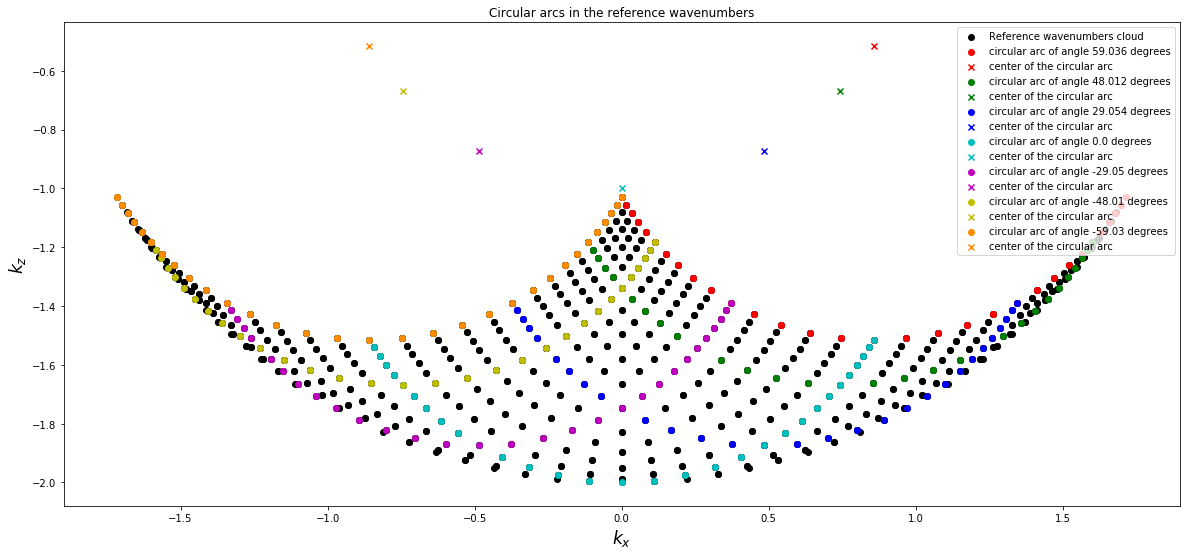

In [5]:
# Arguments
nb_arcs = 7
# the colors of the circular arcs; their number must check nb_arcs 
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange'] 

# We select the indices of the angles phi_s that we will fix to obtain its corresponding circular arc 
indices_selected = np.linspace(start = 0, stop = PhiS_ref.shape[0] - 1, dtype = 'int', num = nb_arcs)
angles_center = PhiS_ref[indices_selected]

Arcs_ref, Centers_ref = compute_circular_arcs(angles_center, PhiR_ref, c0, f0)

# We will plot the reference wavenumbers cloud and circular arcs so we need to create lists for the sets of points,
# the labels, the colors and markers

List = [K_ref]
Labels = ['Reference wavenumbers cloud']
Markers = ['o']
Colors = ['k']

# The labels of the circular arcs and the centers, to be passed to pyplot
Arcs_ref_labels = []
Centers_ref_labels = []

for i in range(len(Arcs_ref)):
    
    # We put the values of the angles phi_s in the labels of the circular arcs
    angle = angles_center[i]
    angle_degrees_str = str(0.001*np.trunc(np.rad2deg(angle)*1000))[:6] # a string to print the fixed angle in degrees
    Arcs_ref_labels.append('circular arc of angle ' + angle_degrees_str + ' degrees')
    
    # The arcs
    List.append(Arcs_ref[i])
    Labels.append(Arcs_ref_labels[i])
    Markers.append('o')
    Colors.append(colors[i])
    
    # The centers
    List.append(Centers_ref[i])
    Labels.append('center of the circular arc')
    Markers.append('x')
    Colors.append(colors[i])
    
plot_wavenumber_cloud(List, labels = Labels, markers = Markers, colors = Colors, title = "Circular arcs in the reference wavenumbers")

In the figure below we try to reconstitute the reference wavenumbers cloud using only circular arcs as defined above. We also plot the centers of the circular arcs.

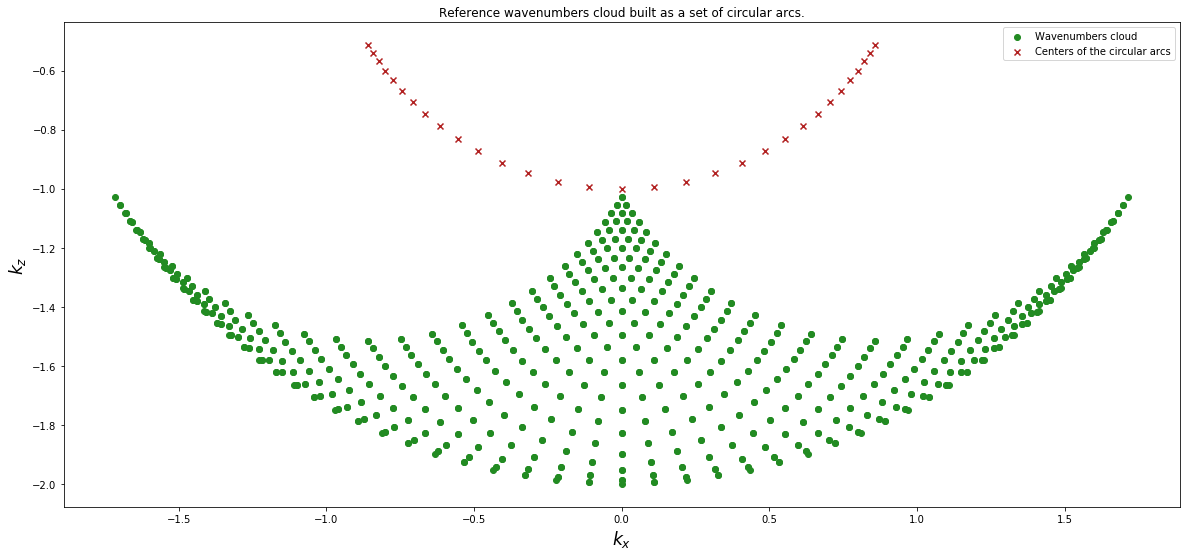

In [6]:
# We will plot the reference cloud generated from circular arcs and the centers of those arcs 
# The componnents of the reference wavenumbers cloud built throuth circular arcs formulation, along with the centers of the arcs
K_circular_arcs_ref, Centers_PhiS_ref  = wavenumbers_circular_arcs(PhiS_ref, PhiR_ref, c0, f0)

# We plot the reference cloud and the associated centers of circular arcs
plot_wavenumber_cloud([K_circular_arcs_ref, Centers_PhiS_ref], markers = ["o", "x"], colors = ['forestgreen', 'firebrick'], labels = ['Wavenumbers cloud', 'Centers of the circular arcs'], title = "Reference wavenumbers cloud built as a set of circular arcs.") 

**Conclusion**: The set $W$ of all possible wavenumbers, considering layouts of maximum angle $\phi_{max}$, can be defined as
$$ W = 
\bigcup_{\phi_s = - \phi_{max}}^{\phi_{max}} \left\{ - \phi_{max} \leq \phi_r \leq \phi_{max} : k_0 \begin{bmatrix} \sin \phi_s  \\ - \cos \phi_s   \end{bmatrix} +  \begin{bmatrix} k_0 \cos ( \phi_r - \frac{\pi}{2}) \\ k_0 \sin ( \phi_r - \frac{\pi}{2} )  \end{bmatrix} \right\} = 
\bigcup_{\phi_s = - \phi_{max}}^{\phi_{max}} \text{Arc}_{\phi_s} $$

where $\text{Arc}_{\phi_s}$ denotes the circular arc of radius $r = k_0$ and center $c = \left( k_0 \sin \phi_s, -  k_0 \cos \phi_s \right)$, generated by angles $\phi_r - \frac{\pi}{2}$ spanning $[- \phi_{max} - \frac{\pi}{2}, \phi_{max} - \frac{\pi}{2} ]$.

We see that the centers of the circular arcs are not regular, this is due to the fact that the discretization of the angles $\phi_s$ and $\phi_r$ are not regular despite the fact that the reference layout (placements of the sources and receivers) is regular. What happens when we regularize the discretization of the space of angles $\phi_s$ and $\phi_r$?

### 2.2 - Regular discretization of the angles $\phi_s$ and $\phi_r$

What happens when we use an equidistant sampling of the incident and adjoint angles $\phi_s$ and $\phi_r$?

We can see that the cloud produced by the angular formula is more homeogemeous, as seen below, than the one produced by the angles of the reference layout. The caveat is that the points in the bottom are too close to each others.

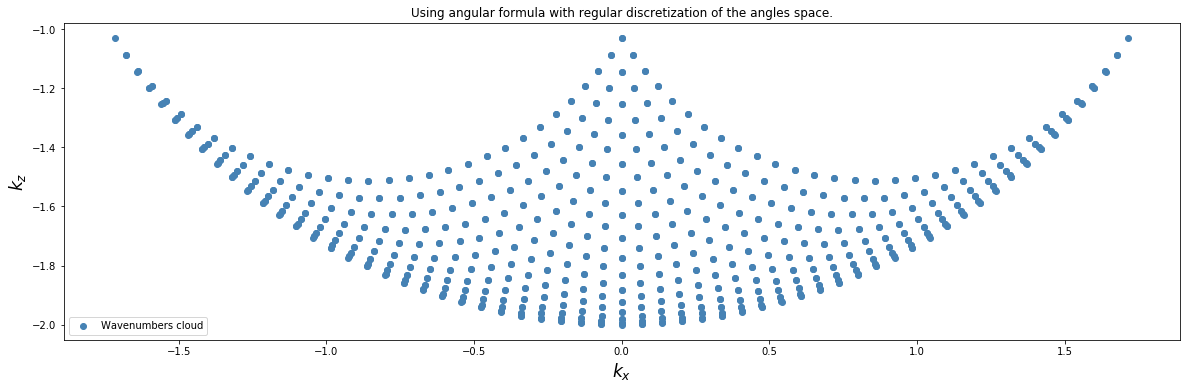

In [7]:
# A regular discretization of the angle \phi_s and \phi_r
PhiS_regular = np.linspace(start = -phi_max, stop = phi_max, num = N)
PhiR_regular = np.linspace(start = -phi_max, stop = phi_max, num = N)
# The components of the wavenumbers obtained using the angular formula
# with a regularized discretization of the angles phi-s and \phi_r space
K_phi_regular = wavenumbers_angular_formula(PhiS_regular, PhiR_regular, c0, f0)
plot_wavenumber_cloud(K_phi_regular, labels = "Wavenumbers cloud", title = "Using angular formula with regular discretization of the angles space.", colors = "steelblue")

If we construct the regular wavenumbers cloud using circular arcs we find that both the centers (defined by $\phi_s$) and the points of the circular arcs (obtained by varying the $\phi_r$'s) are regular.

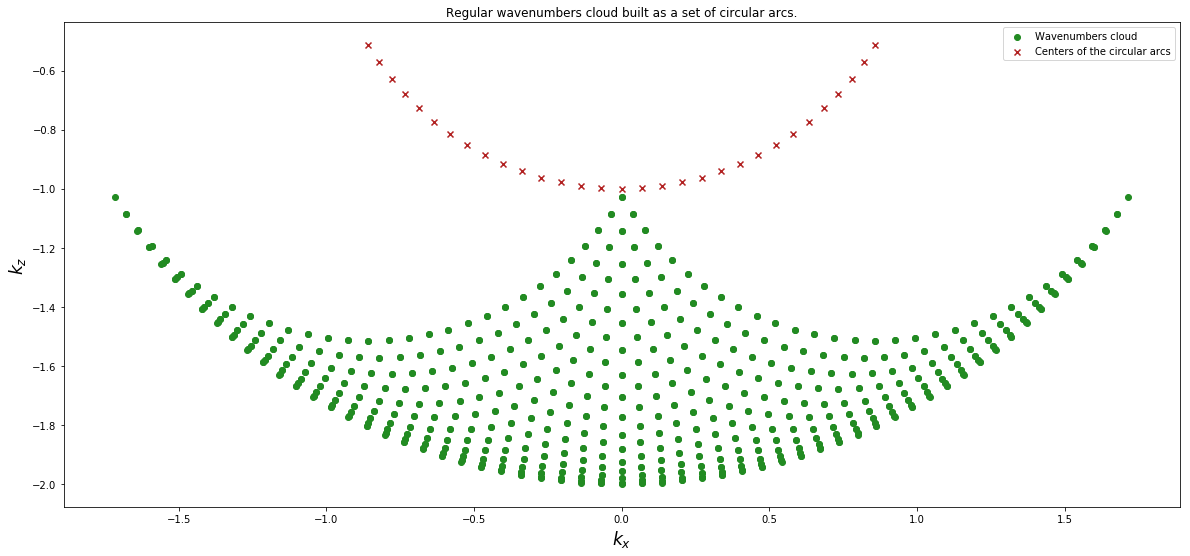

In [8]:
# We will plot the cloud generated from circular arcs using regular discretization of the angles space and the centers of those arcs

# The componnents of the wavenumbers generated by the circular arcs formulation 
# using a regular discretization of the space of angles phi_s and phi_r, along with the centers of the arcs
K_circular_arcs_regular, Centers_PhiS_regular  = wavenumbers_circular_arcs(PhiS_regular, PhiR_regular, c0, f0)

# We plot the reference cloud and the associated centers of circular arcs
plot_wavenumber_cloud([K_circular_arcs_regular, Centers_PhiS_regular], markers = ["o", "x"], colors = ['forestgreen', 'firebrick'], labels = ['Wavenumbers cloud', 'Centers of the circular arcs'], title = "Regular wavenumbers cloud built as a set of circular arcs.") 

We can reconstruct the layout of the sources and receivers on the surface ( we will suppose that their $z$ component is null ) from the sets of angles $\phi_s$ and $\phi_r$. Below is the layout associated to the regular discretization of the angle space.

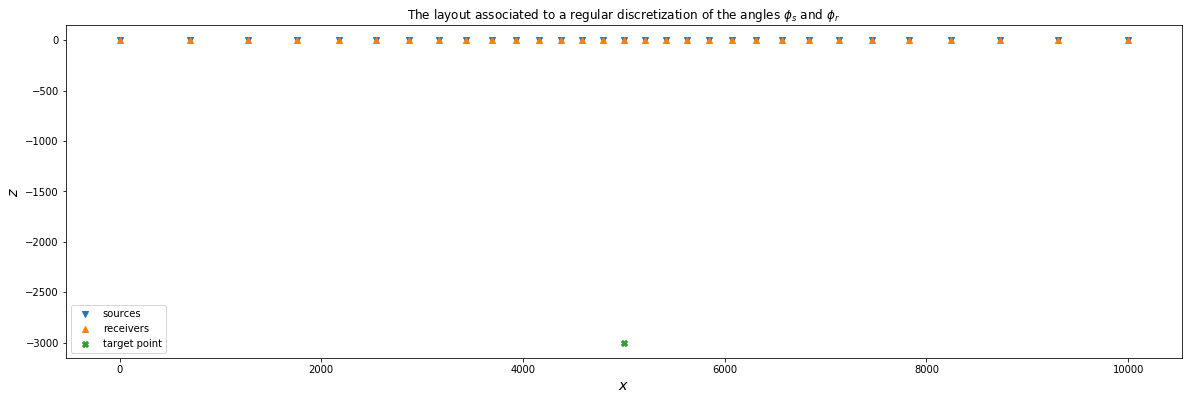

In [9]:
# The positions of the sources and receivers that generates the regular incident and adjoint angles
S_regular, R_regular = angles2layout(PhiS_regular, PhiR_regular, x_diffraction_pt)
plot_acquisition_layout(S_regular, R_regular, x_diffraction_pt, title = "The layout associated to a regular discretization of the angles $\phi_s$ and $\phi_r$")

### 2.3 - Theoric maximum area covered by the wavenumbers cloud

If the sources and receivers spanned the whole surface, reaching infinity on both sides of the diffraction points we would have a theoretic maximum angle $\phi_{max}$ of $\frac{\pi}{2}$. The largest area the wavenumbers cloud can cover will be within the following figure produced by considering $\phi_{max} = \frac{\pi}{2}$.

**Conclusion**: For the cloud to cover a larger area, we have to enlarge the maximum angle $\phi_{max}$.

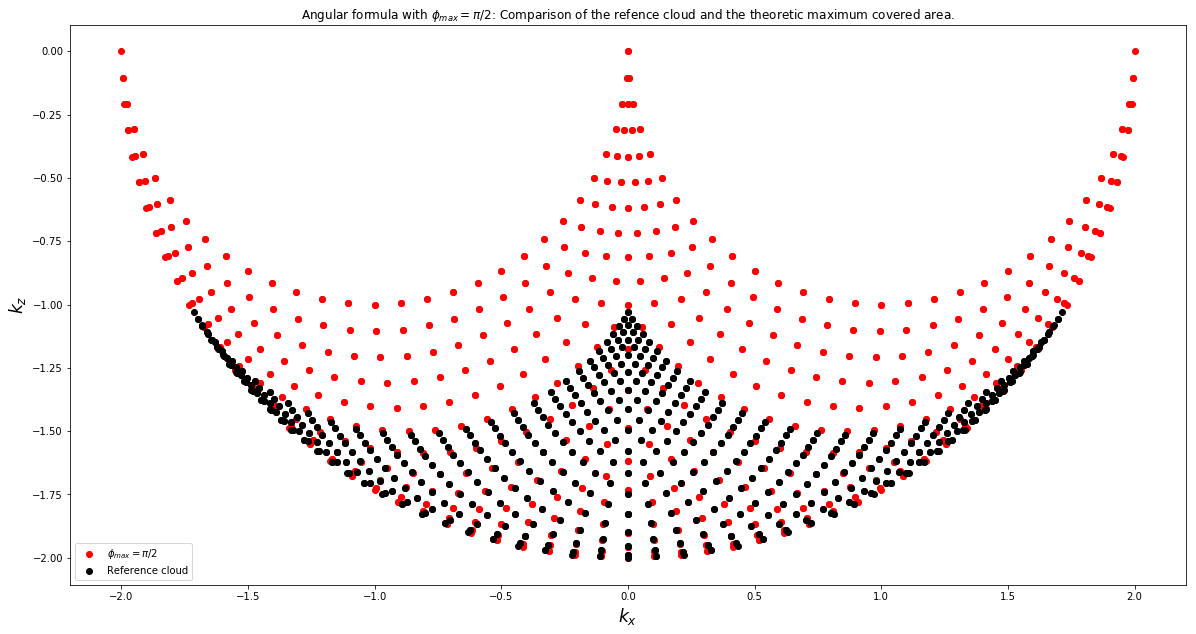

In [10]:
# angles phi_s and phi_r spanning the space [- pi/2, pi/2 ], theoretical limit
PhiS_theory = np.linspace(start = - np.pi/2, stop = np.pi/2, num = N)
PhiR_theory = np.linspace(start = - np.pi/2, stop = np.pi/2, num = N)
# theoric maximum coverage of the wavenumbers components 
K_theory = wavenumbers_angular_formula(PhiS_theory, PhiR_theory, c0, f0) 
plot_wavenumber_cloud([K_theory, K_ref], labels = ['$\phi_{max} =\pi/2$', 'Reference cloud'], title = "Angular formula with $\phi_{max} = \pi/2$: Comparison of the refence cloud and the theoretic maximum covered area.", colors = ['r', 'k'])

## 3 - Other parametrization of the wavenumber cloud

### 3.1 - Bottom circular arc and middle line segment of the wavenumber cloud

The bottom circular arc and middle line segment are shown in the figure below and we also discuss their parametrization.

#### Equal angles

If we fix $\phi_s = \phi_r$ and we vary only the incident angle $\phi_s$ we would get the wavenumbers

$$ k = 2 k_0 \begin{bmatrix} \sin \phi_s \\ - \cos \phi_s\end{bmatrix} \, ,$$

which form a circular arc of center $(0, 0)$ and radius $radius = 2 k_0$; the arc is in fact the bottom circular arc in the wavenumber cloud and corresponds to pairs source/receiver where the two devices share the same position (the vectors $p_s$ and $p_r$ will be equal). 

#### Symmetric angles

If $\phi_r = - \phi_s$ we would have 

$$ k = 2 k_0 \cos (\phi_s ) \begin{bmatrix} 0 \\ - 1 \end{bmatrix} \, ,$$

which represents a line segment of direction $ \begin{bmatrix} 0 \\ - 1 \end{bmatrix} $ and of length $l = 4 k_0 \phi_{\max}$.

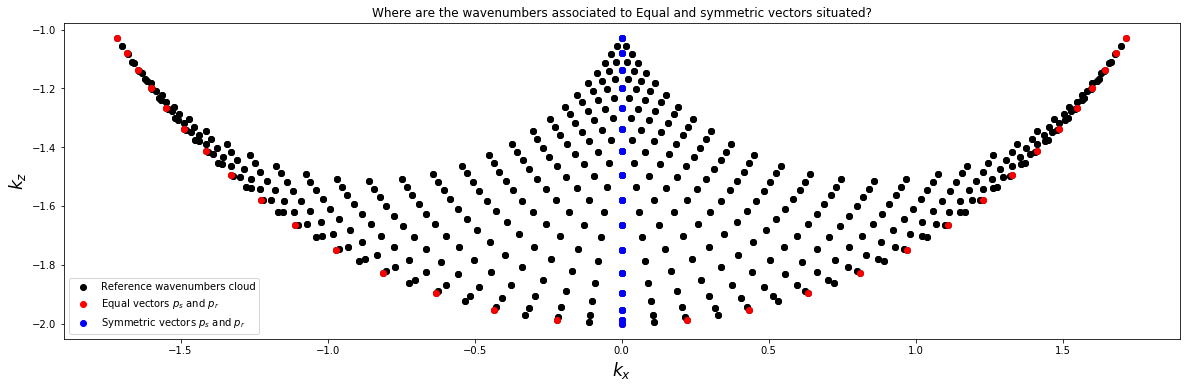

In [11]:
# The wavenumber points generated by equal angles phi_s and phi_r

k0 = (2*np.pi*f0)/c0

Equal = []
for phis in PhiS_ref:
    phir = phis
    k = wavenumber_angles(phis, phir, k0)
    Equal.append(k)
Equal = np.array(Equal)  

# The wavenumber points generated by symmetric angles phi_s and phi_r
Symmetric = []
for phis in PhiS_ref:
    phir = - phis
    k = wavenumber_angles(phis, phir, k0)
    Symmetric.append(k)
Symmetric = np.array(Symmetric)

plot_wavenumber_cloud([K_ref, Equal, Symmetric], labels = ['Reference wavenumbers cloud', 'Equal vectors $p_s$ and $p_r$', 'Symmetric vectors $p_s$ and $p_r$'], colors = ['k', 'r', 'b'], title = "Where are the wavenumbers associated to Equal and symmetric vectors situated?")

### 3.2 - Parametrization by circular arcs of center the origin $O = (0, 0)$

We can generalize the parametrization of the bottom circular arc by fixing $\theta = \frac{\phi_s - \phi_r}{2}$ in the expression of the wavenumber point

$$ k = 2 k_0 \cos \theta \begin{bmatrix} \sin \phi \\ - \cos \phi \end{bmatrix} \, , $$

with $\phi = \frac{\phi_s + \phi_r}{2}$. We would get a circular arc of center $(0, 0)$ and radius $radius = 2 k_0 \cos \theta $.

We express the varying angle $\phi$ as 

$$ \phi = \frac{\phi_s + \phi_r}{2} = \phi_s - \frac{\phi_s - \phi_r}{2} = \phi_s - \theta \, ,$$

so $\phi$ will be a function of $\phi_s$ and $\theta$. The condition on $\phi_s$ (the varying quantity) is that

$$ \phi_{\min} \leq \phi_s \leq \phi_{\max} \, ,$$

with $\phi_{\min} < 0$ and $0 < \phi_{\max}$ are respectively the minimum and maximum values the angles can take. The same inequalities apply to $\phi_r$. 

We find that $\phi_r = \phi_s - 2 \theta$, so the second condition becomes 

$$ \phi_{\min} + 2 \theta \leq \phi_s \leq \phi_{\max} + 2 \theta \, .$$

Combining the two condtions on $\phi_s$ we get 

$$ \max\left( \phi_{\min}, \phi_{\min} + 2 \theta \right) \leq \phi_s \leq \min\left( \phi_{\max}, \phi_{\max} + 2 \theta \right) \, .$$

If we take $\theta$ between $0$ and $\phi_{\max}$ we would get

$$ \phi_{\min} + 2 \theta \leq \phi_s \leq \phi_{\max} \, ,$$

and if we take $\theta$ between $\phi_{\min}$ and $0$ we would get

$$ \phi_{\min} \leq \phi_s \leq \phi_{\max} + 2 \theta \, .$$

Because the radius is an even function of $\theta$ we can consider only positive values of $\theta$ and in the symmetric case ($\phi_{\min} = - \phi_{\max} $) we would have $0 \leq \theta \leq \phi_{\max}$.

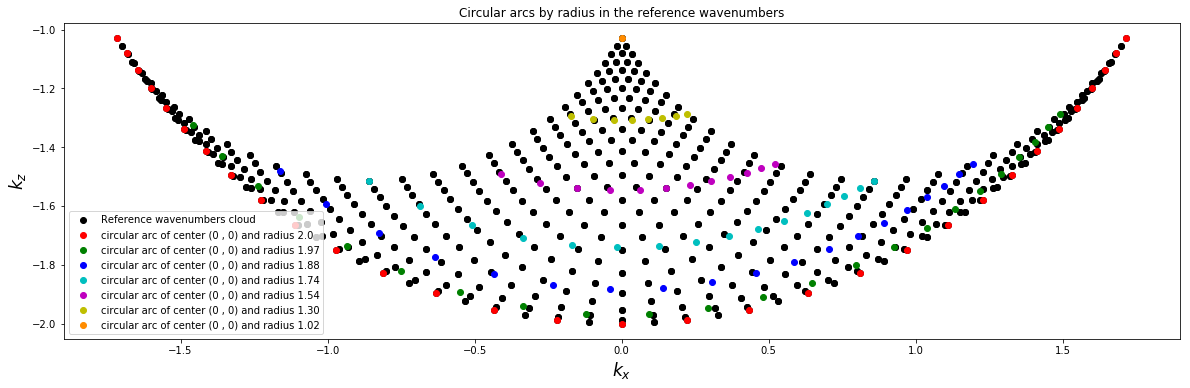

In [12]:
# The parametrization via circular arcs of center the origin

# The parameters of the plot_wavenumber_cloud function
List = [K_ref]
Labels = ['Reference wavenumbers cloud']

# The points go forth and back
fixed = np.linspace(start = 0, stop = phi_max, num = 7)
for i in range(fixed.shape[0]):
    theta = fixed[i] # the fixed angle corresponding to theta
    Arc = []
    
    # We keep the angles phi_s that satisfy: - phi_max + 2 theta <= phi_s
    mask = - phi_max + 2*theta <= PhiS_ref  
    PhiS_theta = PhiS_ref[mask] 
    
    # We generate the points in the arc
    for phis in PhiS_theta:
        phi = phis - theta
        k = 2*np.cos(theta)*np.array( [np.sin(phi), - np.cos(phi)] )
        Arc.append(k)
    
    # Update the lists
    radius = str( 2*k0*np.cos(theta) )[:4] # a string to print the fixed radius
    Labels.append('circular arc of center (0 , 0) and radius ' + radius)
    List.append(np.array(Arc))

Colors = ['k', 'r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'forestgreen'] # The colors of the circular arc
plot_wavenumber_cloud(List, labels = Labels, colors = Colors, title = "Circular arcs by radius in the reference wavenumbers")